In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

# Import relevant packages
from src.eda import data_info
from src.models import AutoencoderTrainer, AnomalyDetector, AutoencoderTuner
import pandas as pd
import warnings
from IPython.display import display
import matplotlib.pyplot as plt
import networkx as nx

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

In [2]:
# Read relevant files
X_train = pd.read_feather("../data/processed/X_train.feather")
X_train_validate = pd.read_feather("../data/processed/X_train_validate.feather")

# Get data info
var_info = data_info(X_train)
all_cols = X_train.columns
real_cols = var_info[var_info["var_type"]=="numerical"]["var_name"].tolist()
binary_cols = var_info[var_info["var_type"]=="binary"]["var_name"].tolist()

In [3]:
print("Real-valued variables:", len(real_cols))
print("Binary variables:", len(binary_cols))

Real-valued variables: 9
Binary variables: 55


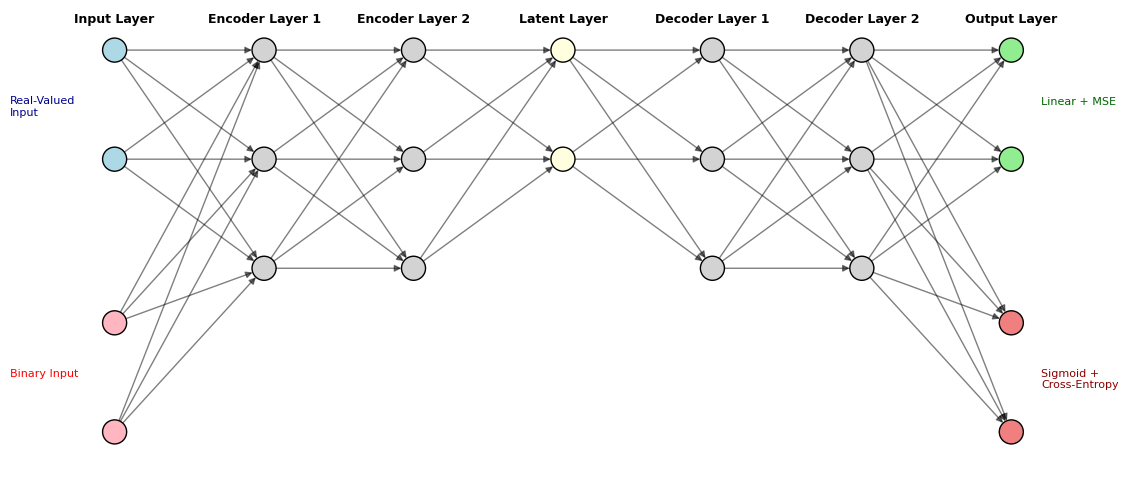

In [4]:
def draw_colored_annotated_autoencoder_graph():
    G = nx.DiGraph()

    # Define layer sizes
    input_real = 2
    input_bin = 2
    encoder_1 = 3
    encoder_2 = 3
    latent = 2
    decoder_1 = 3
    decoder_2 = 3
    output_real = 2
    output_bin = 2

    # Positions for all nodes
    pos = {}
    node_colors = {}

    def place_layer(start_y, n, x, layer_name, color):
        nodes = []
        for i in range(n):
            name = f"{layer_name}_{i}"
            pos[name] = (x, start_y - i)
            nodes.append(name)
            node_colors[name] = color
        return nodes

    # Layers
    input_real_nodes = place_layer(0, input_real, 0, 'in_real', 'lightblue')
    input_bin_nodes = place_layer(-2.5, input_bin, 0, 'in_bin', 'lightpink')
    enc1_nodes = place_layer(0, encoder_1, 1, 'enc1', 'lightgray')
    enc2_nodes = place_layer(0, encoder_2, 2, 'enc2', 'lightgray')
    latent_nodes = place_layer(0, latent, 3, 'z', 'lightyellow')
    dec1_nodes = place_layer(0, decoder_1, 4, 'dec1', 'lightgray')
    dec2_nodes = place_layer(0, decoder_2, 5, 'dec2', 'lightgray')
    out_real_nodes = place_layer(0, output_real, 6, 'out_real', 'lightgreen')
    out_bin_nodes = place_layer(-2.5, output_bin, 6, 'out_bin', 'lightcoral')

    # Add edges
    def connect_all(src, tgt):
        for s in src:
            for t in tgt:
                G.add_edge(s, t)

    connect_all(input_real_nodes + input_bin_nodes, enc1_nodes)
    connect_all(enc1_nodes, enc2_nodes)
    connect_all(enc2_nodes, latent_nodes)
    connect_all(latent_nodes, dec1_nodes)
    connect_all(dec1_nodes, dec2_nodes)
    connect_all(dec2_nodes, out_real_nodes + out_bin_nodes)

    # Prepare node color list
    color_list = [node_colors[n] for n in G.nodes]

    # Draw
    plt.figure(figsize=(14, 6))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=color_list, edgecolors='black')
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    # Add layer labels
    layer_labels = {
        0: "Input Layer",
        1: "Encoder Layer 1",
        2: "Encoder Layer 2",
        3: "Latent Layer",
        4: "Decoder Layer 1",
        5: "Decoder Layer 2",
        6: "Output Layer"
    }

    for x, label in layer_labels.items():
        plt.text(x, 0.25, label, horizontalalignment='center', fontsize=9, fontweight='bold')

    # Add activation/loss labels near output
    plt.text(6.2, -0.5, "Linear + MSE", fontsize=8, color='darkgreen')
    plt.text(6.2, -3.1, "Sigmoid +\nCross-Entropy", fontsize=8, color='darkred')

    # Add activation/loss labels near output
    plt.text(-0.7, -0.6, "Real-Valued\nInput", fontsize=8, color='darkblue')
    plt.text(-0.7, -3.0, "Binary Input", fontsize=8, color='red')

    plt.axis('off')
    plt.show()

draw_colored_annotated_autoencoder_graph()

## Test the trainer

Epoch 1 → Train Loss: 15.0195, Val Loss: 11.2207
Epoch 2 → Train Loss: 10.3556, Val Loss: 8.2611
Epoch 3 → Train Loss: 8.0608, Val Loss: 6.3030
Epoch 4 → Train Loss: 6.5598, Val Loss: 4.9727
Epoch 5 → Train Loss: 5.5281, Val Loss: 4.0658
Epoch 6 → Train Loss: 4.7944, Val Loss: 3.4266
Epoch 7 → Train Loss: 4.2823, Val Loss: 2.9577
Epoch 8 → Train Loss: 3.8541, Val Loss: 2.5987
Epoch 9 → Train Loss: 3.5523, Val Loss: 2.3187
Epoch 10 → Train Loss: 3.2747, Val Loss: 2.0924
Epoch 11 → Train Loss: 3.0589, Val Loss: 1.9064
Epoch 12 → Train Loss: 2.8838, Val Loss: 1.7495
Epoch 13 → Train Loss: 2.7129, Val Loss: 1.6148
Epoch 14 → Train Loss: 2.5770, Val Loss: 1.4981
Epoch 15 → Train Loss: 2.4755, Val Loss: 1.3991
Epoch 16 → Train Loss: 2.3645, Val Loss: 1.3104
Epoch 17 → Train Loss: 2.2635, Val Loss: 1.2298
Epoch 18 → Train Loss: 2.1648, Val Loss: 1.1588
Epoch 19 → Train Loss: 2.1111, Val Loss: 1.0986
Epoch 20 → Train Loss: 2.0294, Val Loss: 1.0415
Epoch 21 → Train Loss: 1.9740, Val Loss: 0.990

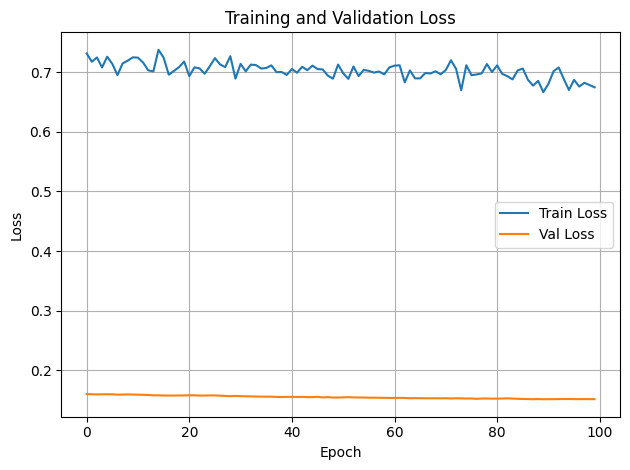

In [5]:
ae = AutoencoderTrainer(
    input_dim=X_train.shape[1],
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    hidden_dims=[64],
    learning_rate=1.5e-2,
    dropout_rate=0.2,
    verbose=True,
    max_epochs=500,
    plot_losses=True
)
autoencoder = ae.train(X_train, X_train_validate)

## Test the anomaly detector

In [6]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# After training
detector = AnomalyDetector(
    model=autoencoder,
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    lam=ae.lam,
)

# Compute scores
scores = detector.compute_anomaly_scores(X_validate)

# Detect
y_pred = detector.detect(scores, 0.3)

# Evaluate
metrics = detector.evaluate(y_pred, y_validate, scores)
print(metrics)

{'accuracy': 0.8221174827616304, 'precision': 0.6287367405978785, 'recall': 0.2828633405639913, 'f1_score': 0.39018551765409937, 'auc': 0.7332975592736982}


## Hyperparameter Tuning

In [ ]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# Define a parameter grid for grid search
param_grid = {
    'hidden_dims': [[64], [64, 32]],
    'batch_size': [32, 64],
    'dropout_rate': [None, 0.1, 0.2, 0.3, 0.5],
    'learning_rate': [0.1, 0.05, 0.02],
    'lam': [1e-4, 1e-3, 1e-2, 1e-1],
    'gamma': [0.2, 0.25, 0.3, 0.35],
}

tuner = AutoencoderTuner(X_train, X_train_validate, X_validate, y_validate, real_cols, binary_cols, all_cols, activation='relu', max_epochs=500, patience_limit=5)
best_model, best_params, best_score, results_df = tuner.sequential_tune(param_grid, metric="f1_score", random_size=10)


Tuning: hidden_dims
	Value: [64]
		 {'batch_size': 64, 'dropout_rate': 0.5, 'learning_rate': 0.05, 'lam': 0.001, 'gamma': 0.2, 'hidden_dims': [64]} - 0.4491879350348028
		 {'batch_size': 64, 'dropout_rate': None, 'learning_rate': 0.1, 'lam': 0.001, 'gamma': 0.25, 'hidden_dims': [64]} - 0.4645011600928074
		 {'batch_size': 64, 'dropout_rate': 0.5, 'learning_rate': 0.02, 'lam': 0.0001, 'gamma': 0.2, 'hidden_dims': [64]} - 0.44733178654292344
		 {'batch_size': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'lam': 0.01, 'gamma': 0.35, 'hidden_dims': [64]} - 0.4510440835266821
		 {'batch_size': 64, 'dropout_rate': None, 'learning_rate': 0.05, 'lam': 0.01, 'gamma': 0.35, 'hidden_dims': [64]} - 0.45614849187935036
	Value: [64, 32]
		 {'batch_size': 64, 'dropout_rate': 0.5, 'learning_rate': 0.05, 'lam': 0.001, 'gamma': 0.2, 'hidden_dims': [64, 32]} - 0.3967369677676084
		 {'batch_size': 64, 'dropout_rate': None, 'learning_rate': 0.1, 'lam': 0.001, 'gamma': 0.25, 'hidden_dims': [64, 32]} - 0.4

In [5]:
results_df

,hidden_dims,batch_size,dropout_rate,learning_rate,lam,gamma,threshold,f1_score
0,[64],32,0.2,0.1,0.0001,0.2,0.155309,0.499801
